# Resume Parsing

## 1. Importing the libraries


In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt

from PyPDF2 import PdfReader
from spacy import displacy

## 2. Loading the data

In [2]:
df_resume = pd.read_csv("data/resume.csv")

Lets find out the unique category found in the resume csv file

In [3]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [4]:
df_resume.shape

(2484, 4)

In [5]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 3. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [6]:
nlp = spacy.load('en_core_web_md')
skill_path = 'data/skills.jsonl'

In [7]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [8]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

## 4. Let's try to extract skills from this resume.csv

In [9]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1112,15119529,CONSULTANT Professional Sum...,"<div class=""MPR skn-cbg1 fontsize fontface vma...",CONSULTANT
2414,11137306,SIMULATOR TECHNICIAN Summar...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
2304,28471099,OWNER Executive Profile O...,"<div class=""fontsize fontface vmargins hmargin...",ARTS
1456,30128072,INTERN Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",CHEF
1113,88907739,CONSULTANT Professional Summary...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT


Lets clean our data by removing stop words and punctuation symbols

In [10]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [11]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         ACCOUNT EXECUTIVE       Summary    Extensive experience in healthcare management, leadership, mentor, healthcare sales, customer service; Succeeded in exceeding targets and expectations; Earned the reputation of being the most dependable and trusted healthcare care employee Recognize for de'

In [12]:
preprocessing(random_resume[:300])

'account executive summary extensive experience healthcare management leadership mentor healthcare sale customer service succeed exceed target expectation earn reputation dependable trust healthcare care employee recognize de'

In [13]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

/var/folders/cc/yxchgkhx74q5gsf46ymlr8gh0000gn/T/ipykernel_67873/1721952070.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'consultant professional summary accomplished seller marketing entrepreneurial chop prove record exceed service standard outpace performance goal solid technical background focus b2b saas programmatic advertising motivated team orient enthusiastic help company grow skill b2b sale network development lead prospecting interpersonal communication skill brand marketing business development product development content creation accounting vc advertising website agency b2b billing book brand strategy budgets business development c com interpersonal communication content content creation client client delivery product development e - commerce editorial finance managing marketing meetings enterprise network sales sell staffing strategic phone tv work history consultant 01/2020 current company name c

In [14]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1112,15119529,CONSULTANT Professional Sum...,"<div class=""MPR skn-cbg1 fontsize fontface vma...",CONSULTANT,consultant professional summary accomplished s...
2414,11137306,SIMULATOR TECHNICIAN Summar...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,simulator technician summary experience electr...
2304,28471099,OWNER Executive Profile O...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,owner executive profile objective driven analy...
1456,30128072,INTERN Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",CHEF,intern highlights microsoft office stata progr...
1113,88907739,CONSULTANT Professional Summary...,"<div class=""fontsize fontface vmargins hmargin...",CONSULTANT,consultant professional summary high achieve m...


## 5. Let's really extract skills!!

In [15]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [16]:
def get_entities(resume):
    
    doc = nlp(resume)

    entities={}
    
    for entity in doc.ents:
        if entity.label_ in entities:
            entities[entity.label_].append(entity.text)
        else:
            entities[entity.label_] = [entity.text]
    for ent_type in entities.keys():
        entities[ent_type]=', '.join(unique_entities(entities[ent_type]))
    return entities

def unique_entities(x):
    return list(set(x))

In [17]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [18]:
df_resume.Skills.iloc[0]

['commerce',
 'communications',
 'chef',
 'finance',
 'schedule',
 'mobile',
 'support',
 'advertising',
 'design',
 'accounting',
 'business',
 'marketing']

## 6. Visualization

Which skills is most important in information management?

In [19]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(49, 6)

In [20]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [21]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [22]:
counting

OrderedDict([('support', 46),
             ('software', 41),
             ('design', 37),
             ('business', 36),
             ('security', 35),
             ('server', 34),
             ('windows', 32),
             ('database', 28),
             ('project management', 21),
             ('documentation', 19)])

<BarContainer object of 10 artists>

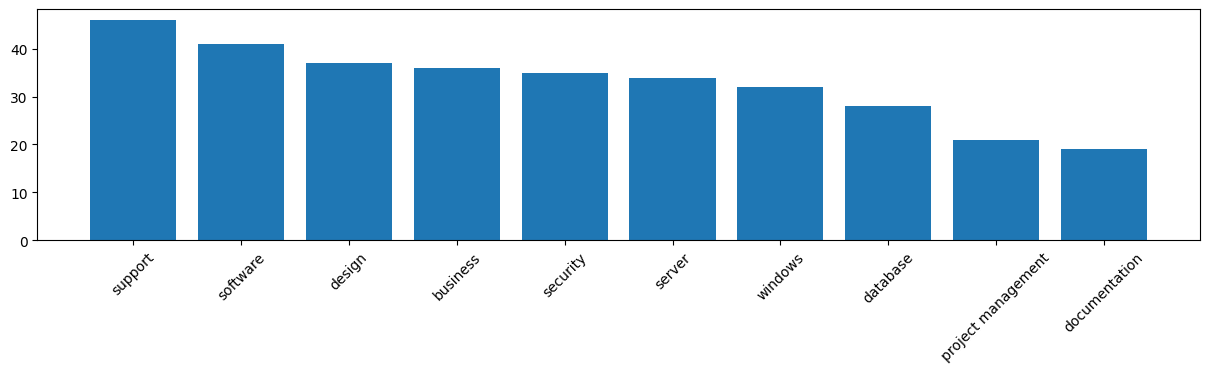

In [23]:
plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 7. Let's load the PDF - add some realism

In [24]:
reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()
text = preprocessing(text)
doc = nlp(text)

In [25]:
colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"},
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)